### 1. Importing necessary libraries

In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score
)
from utils.utils import split_data, plot_confusion_matrix

from crack_segmentation.subroutines.loss_metrics import (
    Weighted_Cross_Entropy,
    F1_score,
    Precision_dil,
    F1_score_dil
)

### 2. Loading the dataset

In [11]:
dataset = pd.read_csv('../dataset/dataset_final.csv')

dataset['Filepath'] = dataset['Filepath'].apply(lambda x: "../" + x)

train_df, test_df = train_test_split(
    dataset.sample(frac=1.0, random_state=42),
    train_size=0.80,
    random_state=42
)

train_data, valid_data, test_data = split_data(train_df, test_df, image_width=224, image_height=224, class_mode='categorical')

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


### 3. Loading the Unet-MobileNet model

In [12]:
model = tf.keras.models.load_model(
    'crack_segmentation/output/checkpoints/unet_mobilenet.h5',
    custom_objects={
        'loss': Weighted_Cross_Entropy(10),
        'F1_score': F1_score,
        'F1_score_dil': F1_score_dil,
        'Precision_dil': Precision_dil
    }
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 225, 225, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                          

### 4. Making predictions

In [13]:
y_pred = np.argmax(model.predict(test_data), axis=-1)

250/250 [==============================] - 756s 3s/step


In [14]:
print(y_pred)

[0 1 1 ... 0 0 0]


#### 4.1. Classification report

In [15]:
cr = classification_report(test_data.labels, y_pred)

print(cr)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3981
           1       1.00      0.95      0.97      4019

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000



#### 4.2. F1, Precision and Recall Score

In [16]:
x = f1_score(test_data.labels, y_pred, average='weighted')
y = precision_score(test_data.labels, y_pred, average='weighted')
z = recall_score(test_data.labels, y_pred, average='weighted')

In [17]:
print(f'F1 score: {x}')
print(f'Precision: {y}')
print(f'Recall: {z}')

F1 score: 0.9729875213758898
Precision: 0.9740980018811439
Recall: 0.973


#### 4.3. Confusion matrix

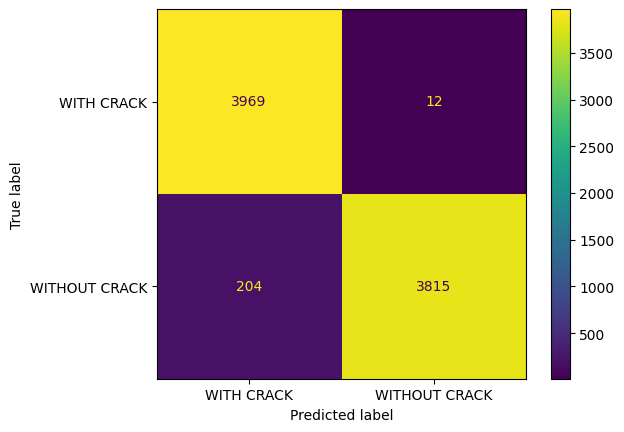

In [18]:
disp = plot_confusion_matrix(test_data.labels, y_pred, title='Unet MobileNet')

plt.show()

#### 4.4. Plot images

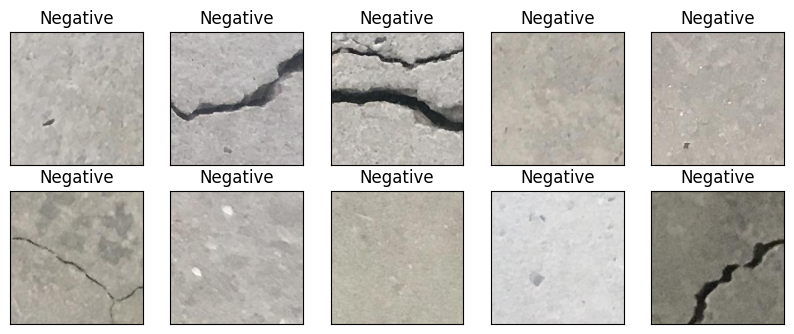

In [19]:
class_names = ['Negative', 'Positive']
fig = plt.figure(figsize=(10,10))

for i in range(10):
    ax = fig.add_subplot(5,5, i + 1, xticks=[], yticks=[])
    ax.imshow(test_data[0][0][i])
    x = class_names[np.argmax(y_pred[i])]
    ax.set_title("{}".format(x))

1/1 [==============================] - 0s 127ms/step


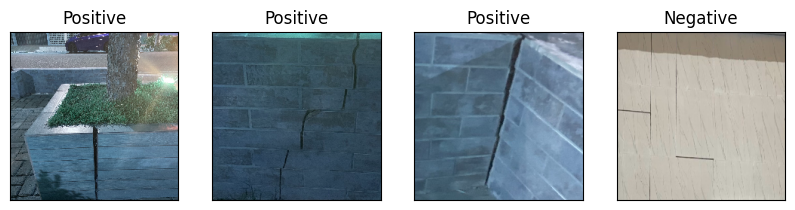

In [20]:
fig = plt.figure(figsize=(10,10))

for x in range(4):
    img_path = cv2.imread(f"crack_segmentation/notebook/images/amostra{x + 1}.jpg")
    img_path = cv2.resize(img_path, (224,224))
    img = np.expand_dims(img_path, axis=0)
    img = img / 255.0
    
    ax = fig.add_subplot(1, 4, x + 1, xticks=[], yticks=[])
    pred = model.predict(img)
    t = class_names[np.argmax(pred[0])]
    ax.set_title("{}".format(t))
    ax.imshow(img_path)

### 5. Evaluating the model

In [ ]:
loss, acc = model.evaluate(test_data)

In [22]:
print(f'acc: {acc}')
print(f'loss: {loss}')

acc: 0.9729999899864197
loss: 2.9123690128326416
